# Food recognition with Transfer Learning

**Leveraging transfer learning (EfficientNet_B0) for image classification Food101 extract dataset**

# 0. Initial setup

In [1]:
# Import necessary libraries
import torch
from torch import nn
import torchvision
from torchvision import transforms

import os
import requests
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# Import or download and import torchinfo
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Import or download from GitHub and import modular approach scripts
try:
    from modular_approach_scripts import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find modular_approach scripts... downloading them from GitHub.")
    !git clone https://github.com/slawomirwojtas/ML-Projects
    !mv ML-Projects/modular_approach_scripts .
    !rm -rf ML-Projects
    from modular_approach_scripts import data_setup, engine


print(torch.__version__)
print(torchvision.__version__)

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find modular_approach scripts... downloading them from GitHub.
Cloning into 'ML-Projects'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 48 (delta 6), reused 16 (delta 2), pack-reused 23
Receiving objects: 100% (48/48), 100.30 MiB | 19.99 MiB/s, done.
Resolving deltas: 100% (16/16), done.
2.1.0+cu118
0.16.0+cu118


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Download data

In [3]:
# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "food101_extract"

# Create data folder if doesn't exist
if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  image_path.mkdir(parents=True, exist_ok=True)
  print(f"{image_path} directory created")

  # Download food101_extract data
  with open(data_path / "food101_extract.zip", "wb") as f:
    request = requests.get("https://github.com/slawomirwojtas/ML-Projects/raw/main/food101_extract.zip")
    print("Downloading food101_extract data...")
    f.write(request.content)

  # Unzip food101_extract data
  with zipfile.ZipFile(data_path / "food101_extract.zip", "r") as zip_ref:
    print("Unzipping food101_extract data...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "food101_extract.zip")

print("Done")

data/food101_extract directory created
Unzipping food101_extract data...
Done


In [4]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/food101_extract/train'),
 PosixPath('data/food101_extract/test'))

# 2. Create Datasets and DataLoaders

In [5]:
# Create a transform applicable for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [6]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff8026639a0>,
 ['cheesecake', 'gnocchi', 'guacamole', 'hamburger', 'paella'])

# 3. Get a pre-trained model EfficientNetB0

In [7]:
# Create a pretrained model

### This code might be erroneous on particular versions
# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# model = torchvision.models.efficientnet_b0(weights=weights).to(device)

### Workaround solution involving overwriting state_dict
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model = efficientnet_b0(weights="DEFAULT")
# model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 67.3MB/s]


In [8]:
# Getting a model summary with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channles, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [9]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  #print(param)
  param.requires_grad = False

In [10]:
# Update the classifier head of our model to suit our problem
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), # method for regularization
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names))).to(device) # how many classes do we have?

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)

In [11]:
# See the changes made on the model summary
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channles, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 5]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# 4. Train model

In [12]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [13]:
# Import train function
from modular_approach_scripts import engine

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.2f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3552 | train_acc: 0.5062 | test_loss: 0.9550 | test_acc: 0.8527
Epoch: 2 | train_loss: 0.9228 | train_acc: 0.8075 | test_loss: 0.6878 | test_acc: 0.8929
Epoch: 3 | train_loss: 0.7112 | train_acc: 0.8500 | test_loss: 0.5537 | test_acc: 0.9062
Epoch: 4 | train_loss: 0.5886 | train_acc: 0.8700 | test_loss: 0.4960 | test_acc: 0.8884
Epoch: 5 | train_loss: 0.5100 | train_acc: 0.8838 | test_loss: 0.4250 | test_acc: 0.9196
Epoch: 6 | train_loss: 0.4752 | train_acc: 0.8825 | test_loss: 0.3955 | test_acc: 0.9107
Epoch: 7 | train_loss: 0.4239 | train_acc: 0.9038 | test_loss: 0.3635 | test_acc: 0.9107
Epoch: 8 | train_loss: 0.4067 | train_acc: 0.9025 | test_loss: 0.3543 | test_acc: 0.9152
Epoch: 9 | train_loss: 0.3646 | train_acc: 0.9187 | test_loss: 0.3339 | test_acc: 0.9107
Epoch: 10 | train_loss: 0.3597 | train_acc: 0.9075 | test_loss: 0.3284 | test_acc: 0.9152
[INFO] Total training time: 75.50 seconds


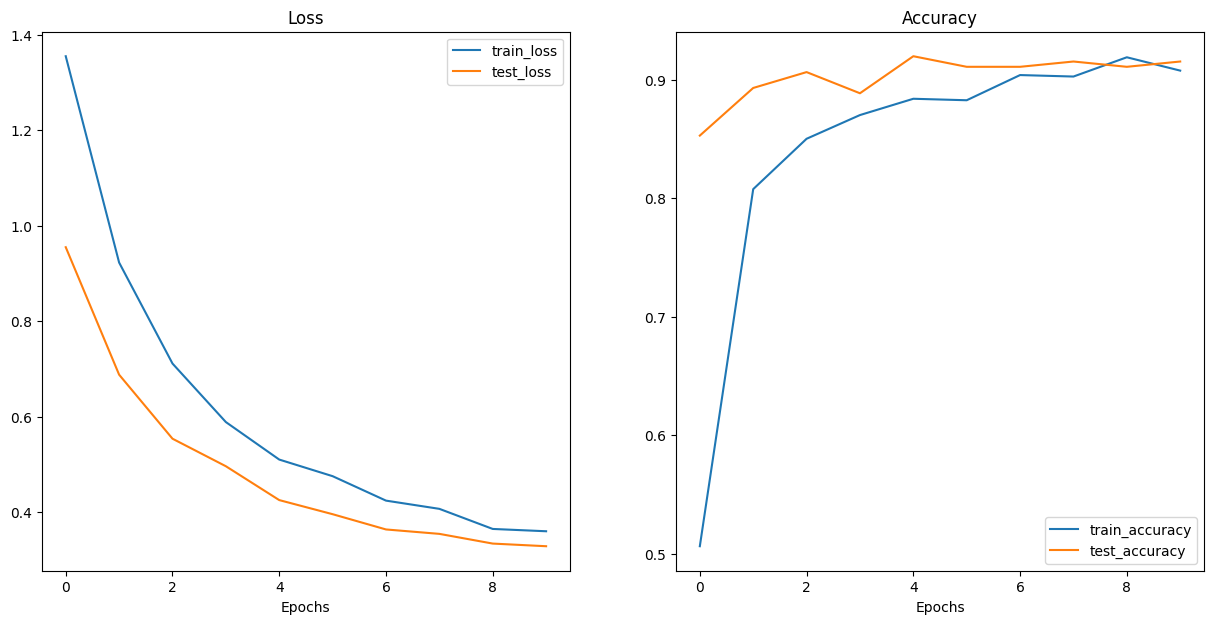

In [14]:
# Evaluate model by plotting loss curves
from modular_approach_scripts import utils

utils.plot_loss_curves(results)

# 5. Evaluate the model

### 5.1 Make predictions on random images from the test set

In [15]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # Open the image with PIL
  img = Image.open(image_path)

  # Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])
    ])

  ### Predict on image ###
  # Ensure the model is on the target device
  model.to(device)

  # Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

    # Make a prediction on the transformed image by passing it to the model (also ensure it's on the target device)
    target_image_pred = model(transformed_image.to(device))

  # Convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot image with predicted label and probability
  plt.figure(figsize=(10, 7))
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)

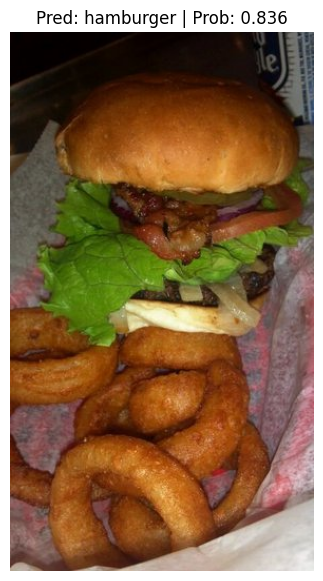

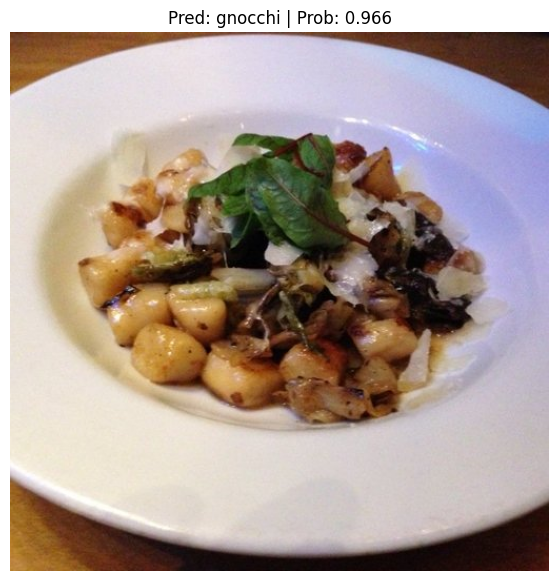

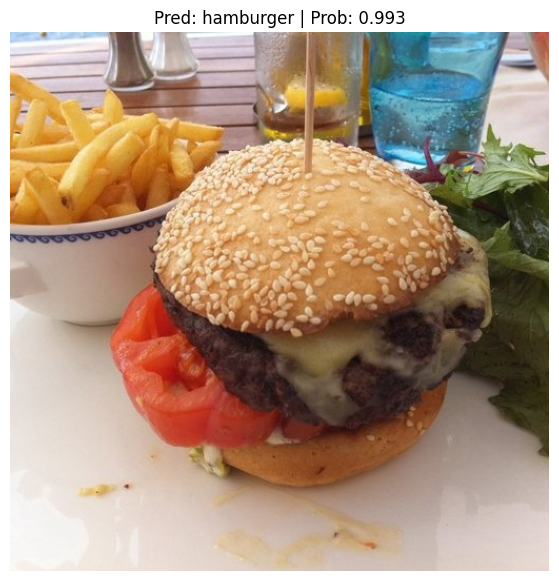

In [17]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predicitons on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

### 5.2 Evaluate on the entire test dataset with a confusion matrix

In [18]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.2 MB/s eta 0:00:00
mlxtend version: 0.23.0


In [19]:
# Make predictions on the entire test dataset
from tqdm.auto import tqdm

test_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Forward pass, get logits
    test_logits = model(X)
    # Convert logits to probabilities
    test_probs = torch.softmax(test_logits, dim=1)
    # Get the highest probability = class index
    test_labels = torch.argmax(test_probs, dim=1)
    # Add the predicted label to the results list
    test_preds.append(test_labels)

# Concatenate the test labels and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/7 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 4, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 2, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4])

In [20]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4])

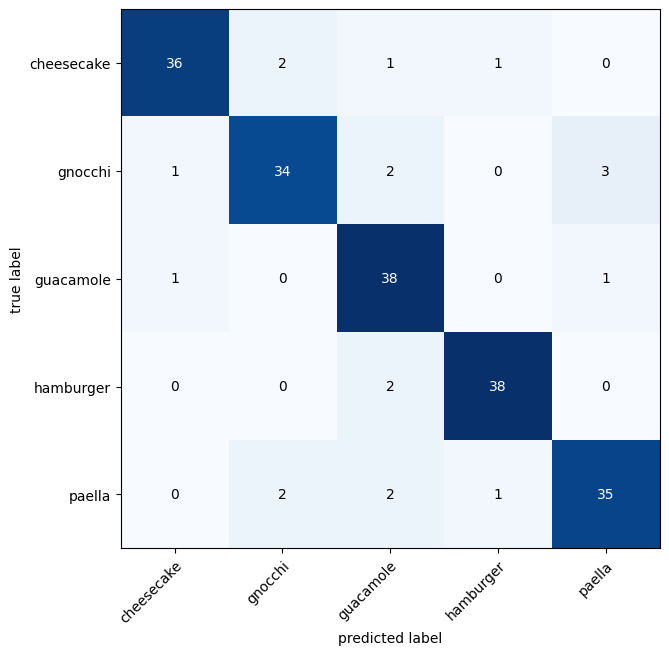

In [21]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(task="multiclass",
                          num_classes=len(class_names))
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

### 5.3 Create a log containing data about all predictions from the test dataset

In [22]:
# Get all test data paths
from pathlib import Path
from typing import List, Tuple
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]



def pred_and_store(test_paths,
                   model: torch.nn.Module,
                   class_names: List[str],
                   image_size: Tuple[int, int] = (224, 224),
                   transform: torchvision.transforms = None,
                   device: torch.device=device):
  """
  Creates a pandas DataFrame containing details about target model's predictions.
  """

  # Create Dataframe collector
  class_cols = []
  for item in class_names:
    class_cols.append("prob_" + item)
  collector_cols = ["image_path", "class_name"] + class_cols + ["pred_class", "pred_prob", "correct"]
  df = pd.DataFrame(columns=collector_cols)

  # Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])
    ])

  # Iterate through images to collect prediction and prediction probabilities
  for path in tqdm(test_data_paths):
    results = []

    # collect path
    results.append(str(path))

    # collect class name
    class_name = path.parent.stem
    results.append(class_name)

    ## collect predictions
    from PIL import Image
    img = Image.open(path)
    transformed_image = image_transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():

        # collect all classes probabilities
        pred_logit = model(transformed_image.to(device))
        pred_prob = torch.softmax(pred_logit, dim=1)
        results.extend(pred_prob.unsqueeze(0).cpu().tolist()[0][0])

        # collect predicted class
        pred_label = torch.argmax(pred_prob, dim=1)
        pred_class = class_names[pred_label.cpu()]
        results.append(pred_class)

        # collect predicted probability
        results.append(pred_prob.unsqueeze(0).max().cpu().item())

        # collect prediction result
        correct = class_name == pred_class
        results.append(correct)

    # Add results to the collector dataframe
    df.loc[len(df)] = results

  return df

prediction_log = pred_and_store(test_paths=test_data_paths,
                                model=model,
                                class_names=class_names,
                                image_size=(224, 224),
                                transform=auto_transforms)

prediction_log.head()

  0%|          | 0/200 [00:00<?, ?it/s]

,image_path,class_name,prob_cheesecake,prob_gnocchi,prob_guacamole,prob_hamburger,prob_paella,pred_class,pred_prob,correct
0,data/food101_extract/test/hamburger/100517.jpg,hamburger,0.086602,0.027671,0.006753,0.797826,0.081147,hamburger,0.797826,True
1,data/food101_extract/test/hamburger/1447114.jpg,hamburger,0.009905,0.008407,0.490768,0.413303,0.077616,guacamole,0.490768,False
2,data/food101_extract/test/hamburger/611133.jpg,hamburger,0.002868,0.001510,0.045024,0.923383,0.027215,hamburger,0.923383,True
3,data/food101_extract/test/hamburger/3220288.jpg,hamburger,0.071179,0.000184,0.005040,0.921753,0.001845,hamburger,0.921753,True
4,data/food101_extract/test/hamburger/3510148.jpg,hamburger,0.000772,0.000139,0.000289,0.998606,0.000195,hamburger,0.998606,True


### 5.4 Make a prediction on a custom image

Done


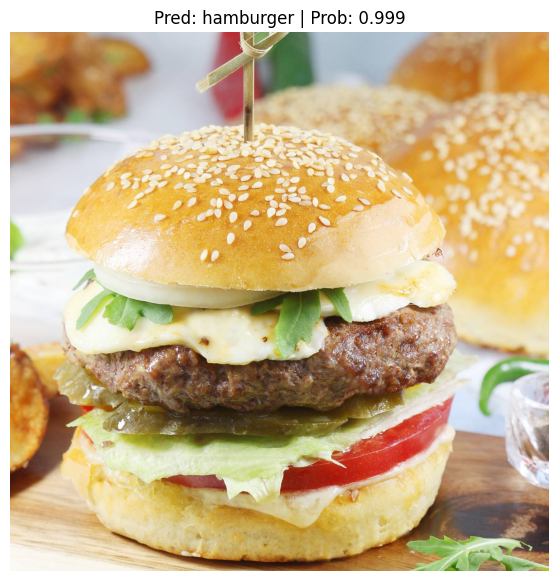

In [23]:
# Setup custom image path
data_path = Path("data/")
custom_image_path = data_path / "predict_image.jpeg"

IMAGE_URL = "https://cdn.aniagotuje.com/pictures/articles/2020/05/3989474-v-1500x1500.jpg"


# Download the image
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get(IMAGE_URL)
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, overwriting content...")
  with open(custom_image_path, "wb") as f:
    request = requests.get(IMAGE_URL)
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
print("Done")


# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

# 6. Save the model

In [24]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "EffNetB0_for_Food101_Extract.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)
print("Done")

Saving model to models/EffNetB0_for_Food101_Extract.pth
Done
